# Compare across random seeds
##### authors: Elizabeth A. Barnes and Noah Diffenbaugh
##### date: March 25, 2022


## Python stuff

In [1]:
import sys, imp, os, copy, tqdm

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import tensorflow as tf
import tensorflow_probability as tfp
import silence_tensorflow
silence_tensorflow

import scipy.stats as stats
import seaborn as sns
from tqdm import tqdm

import experiment_settings
import file_methods, plots, data_processing, custom_metrics, network

import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
savefig_dpi = 300
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

import warnings
warnings.filterwarnings("ignore")

In [2]:
print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"xarray version = {xr.__version__}")  
print(f"tensorflow version = {tf.__version__}")  
print(f"tensorflow-probability version = {tfp.__version__}")  

python version = 3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:27:43) 
[Clang 11.1.0 ]
numpy version = 1.22.2
xarray version = 2022.3.0
tensorflow version = 2.7.0
tensorflow-probability version = 0.15.0


## User Choices

In [3]:
EXP_NAME_VEC = (
                'exp11C_370','exp15C_370','exp20C_370','exp15C_126','exp20C_126',
                'exp0','exp1','exp2','exp3','exp4','exp5',    # ridge sweep w/ hiddens = [10,10]
                'exp10','exp11','exp12','exp13','exp14',      # hiddens sweep w/ ridge = 10.0
                'exp20','exp21','exp22','exp23',              # hiddens sweep w/ ridge = 5.0                
                'exp30','exp31','exp32','exp33',              # ridge sweep w/ hiddens = [25,25]
               )

LOOP_THROUGH_EXP = True
SAVE_FILE = True
LOAD_METRICS = True

#-------------------------------------------------------

MODEL_DIRECTORY = 'saved_models/'        
PREDICTIONS_DIRECTORY = 'saved_predictions/'
DATA_DIRECTORY = 'data/'
DIAGNOSTICS_DIRECTORY = 'model_diagnostics/'
FIGURE_DIRECTORY = 'figures/'

## Plotting Functions

In [4]:
FS = 10
palette=("tab:gray","tab:purple","tab:orange","tab:blue","tab:red","tab:green",)

### for white background...
# plt.rc('text',usetex=True)
plt.rc('text',usetex=False)
# plt.rc('font',**{'family':'sans-serif','sans-serif':['Avant Garde']}) 
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']}) 
plt.rc('savefig',facecolor='white')
plt.rc('axes',facecolor='white')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('xtick',color='dimgrey')
plt.rc('ytick',color='dimgrey')
################################  
################################  
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')  
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        ax.xaxis.set_ticks([]) 

def format_spines(ax):
    adjust_spines(ax, ['left', 'bottom'])
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('dimgrey')
    ax.spines['bottom'].set_color('dimgrey')
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params('both',length=4,width=2,which='major',color='dimgrey')
#     ax.yaxis.grid(zorder=1,color='dimgrey',alpha=0.35)    
    

## Get obs

In [5]:
# load observations for diagnostics plotting
settings = experiment_settings.get_settings("exp0")
da_obs, x_obs, global_mean_obs = data_processing.get_observations(DATA_DIRECTORY, settings)

observations: filling NaNs with zeros
np.shape(x_obs) = (172, 10368)


## Analyze CMIP results across random seeds

In [6]:
df_metrics = pd.DataFrame()
if LOAD_METRICS == True:
    df_metrics = pd.read_pickle(PREDICTIONS_DIRECTORY + "df_random_seed.pickle")

    
if LOOP_THROUGH_EXP == True:
    for exp_name in EXP_NAME_VEC:
        settings = experiment_settings.get_settings(exp_name)
        rng = np.random.default_rng(settings["rng_seed"])    
        print(exp_name)

        for iloop in np.arange(settings['n_models']):
            seed = rng.integers(low=1_000,high=10_000,size=1)[0]
            settings["seed"] = int(seed)
            tf.random.set_seed(settings["seed"])
            np.random.seed(settings["seed"])

            # check if entry exists
            if LOAD_METRICS == True:
                entry = df_metrics[(df_metrics["exp_name"]==exp_name) & (df_metrics["seed"]==settings["seed"])]
                if len(entry) > 0:
                    continue
            
            # get model name
            model_name = file_methods.get_model_name(settings)
            if os.path.exists(MODEL_DIRECTORY + model_name + "_model") == False:               
                continue
            model = file_methods.load_tf_model(model_name, MODEL_DIRECTORY)
            # get the data
            (x_train, 
             x_val, 
             x_test, 
             y_train, 
             y_val, 
             y_test, 
             onehot_train, 
             onehot_val, 
             onehot_test, 
             y_yrs_train, 
             y_yrs_val, 
             y_yrs_test, 
             target_years, 
             map_shape,
             settings) = data_processing.get_cmip_data(DATA_DIRECTORY, settings, verbose=0)

            #----------------------------------------        
            # make predictions for observations and cmip results
            pred_train = model.predict(x_train)
            pred_val = model.predict(x_val)
            pred_test = model.predict(x_test) 
            pred_obs = model.predict(x_obs)

            #----------------------------------------        
            # compute metrics to compare
            error_val = np.mean(np.abs(pred_val[:,0] - onehot_val[:,0]))
            error_test = np.mean(np.abs(pred_test[:,0] - onehot_test[:,0]))    
            __, __, d_val, __ = custom_metrics.compute_pit(onehot_val, x_data=x_val, model_shash = model)
            __, __, d_test, __ = custom_metrics.compute_pit(onehot_test, x_data=x_test, model_shash = model)    
            __, __, d_valtest, __ = custom_metrics.compute_pit(np.append(onehot_val,onehot_test,axis=0), x_data=np.append(x_val,x_test,axis=0), model_shash = model)    
            loss_val = network.RegressLossExpSigma(onehot_val,pred_val).numpy()
            loss_test = network.RegressLossExpSigma(onehot_test,pred_test).numpy()
            
            d = {}
            d["exp_name"] = settings["exp_name"]
            d["seed"] = settings["seed"]
            d["hiddens"] = str(settings["hiddens"])
            d["ridge_param"] = settings["ridge_param"][0]        
            d["error_val"] = error_val
            d["error_test"] = error_test
            d["loss_val"] = loss_val
            d["loss_test"] = loss_test            
            d["d_val"] = d_val
            d["d_test"] = d_test
            d["d_valtest"] = d_valtest
            d["obs_2021_mu"] = pred_obs[-1][0]
            d["obs_2021_sigma"] = pred_obs[-1][1]            

            df = pd.DataFrame(d, index=[0])
            df_metrics = pd.concat([df_metrics,df])
            
    df_metrics = df_metrics.drop_duplicates(ignore_index=True)
    
    if SAVE_FILE:
        df_metrics.to_pickle(PREDICTIONS_DIRECTORY + "df_random_seed.pickle")
        
    display(df_metrics)

exp11C_370
exp15C_370
exp20C_370
exp15C_126


2022-03-26 12:21:38.589170: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


exp20C_126
exp0
exp1
exp2
exp3
exp4
exp5
exp10
exp11
exp12
exp13
exp14
exp20
exp21
exp22
exp23
exp30
exp31
exp32
exp33


,exp_name,seed,hiddens,ridge_param,error_val,error_test,loss_val,loss_test,d_val,d_test,d_valtest,obs_2021_mu,obs_2021_sigma
0,exp11C_370,1257,"[25, 25]",10.0,2.669777,3.021976,2.410108,2.598861,0.003618,0.028654,0.009814,-0.358603,4.475694
1,exp11C_370,5322,"[25, 25]",10.0,3.076258,3.212429,2.585819,2.689434,0.011924,0.028151,0.013970,0.410671,5.034152
2,exp11C_370,2247,"[25, 25]",10.0,2.975179,2.653132,2.532525,2.422840,0.014915,0.020055,0.012506,1.021940,4.943808
3,exp11C_370,5757,"[25, 25]",10.0,3.409314,2.992531,2.734041,2.628276,0.010046,0.016668,0.007692,-0.049635,5.479080
4,exp11C_370,1170,"[25, 25]",10.0,3.159706,2.782710,2.632599,2.531530,0.010644,0.025927,0.012920,0.264917,5.880829
...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,exp15C_126,9156,"[25, 25]",10.0,6.400194,7.020482,3.492607,3.649353,0.019179,0.041428,0.023809,11.368870,9.154469
236,exp15C_126,6613,"[25, 25]",10.0,7.298006,7.334703,3.608699,3.738018,0.025101,0.031833,0.021035,13.462597,8.559092
237,exp15C_126,9983,"[25, 25]",10.0,6.876158,5.698988,3.518158,3.385922,0.022214,0.028755,0.016546,13.326813,7.638296
238,exp15C_126,4348,"[25, 25]",10.0,7.170436,6.728457,3.608949,3.527229,0.020770,0.030190,0.022179,13.406134,8.505761


In [7]:
error('here')

NameError: name 'error' is not defined

## Random seeds for obs

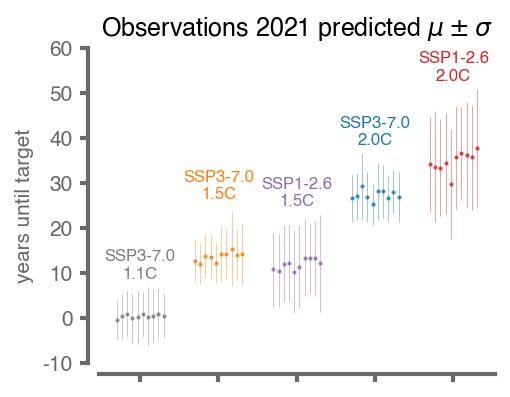

In [47]:
# PLOT ACROSS SSPs and TARGETS
EXP_FOR_PLOTTING = ('exp11C_370','exp15C_370','exp15C_126','exp20C_370','exp20C_126')
df_metrics_plot = df_metrics[df_metrics["exp_name"].isin(EXP_FOR_PLOTTING)]
df_metrics_plot = df_metrics_plot.sort_values("exp_name")
clr_order = [0,2,1,3,4,5]
x_labels = EXP_FOR_PLOTTING
#------------------------------------------------------------
fig, ax = plt.subplots(1,1,figsize=(3.5,2.75))

for iexp,exp_name in enumerate(EXP_FOR_PLOTTING):
    iplot = np.where(df_metrics["exp_name"]==exp_name)[0]
    
    ax.errorbar(np.ones(iplot.shape)*iexp+np.linspace(-.3,.3,len(iplot)),
            df_metrics.iloc[iplot]["obs_2021_mu"],
            yerr=df_metrics.iloc[iplot]["obs_2021_sigma"],
            color=np.array(palette)[clr_order][iexp],
            marker='.',
            linestyle='',
            elinewidth=.25,
            markersize=2,
            alpha=.8,
           )
    max_y_value = np.max(df_metrics.iloc[iplot]["obs_2021_mu"]+df_metrics.iloc[iplot]["obs_2021_sigma"])
    if exp_name=='exp15C_370':
        add_val = 3
    else:
        add_val = 2
    text_name = 'SSP'+exp_name[7]+'-'+exp_name[8] + '.' + exp_name[9] + '\n' +exp_name[3] + '.' + exp_name[4]+'C'
    
    plt.text(iexp,
             max_y_value+add_val,
             text_name,
             fontsize=FS*0.8,
             color=np.array(palette)[clr_order][iexp],
             horizontalalignment='center',
            )
             

ax.set_ylabel('years until target')
ax.set_title('Observations 2021 predicted $\mu \pm \sigma$')
ax.set_xlabel(None)
format_spines(ax)
ax.set_xticks(np.arange(0,len(x_labels)),'', fontsize=FS*0.8,rotation=45)
ax.set_yticks(np.arange(-100,100,10),np.arange(-100,100,10).round())
ax.set_ylim(-10,60)

plt.tight_layout()
plots.savefig(FIGURE_DIRECTORY + 'obs_params_ssp_target_comparison',dpi=savefig_dpi)
plt.show()


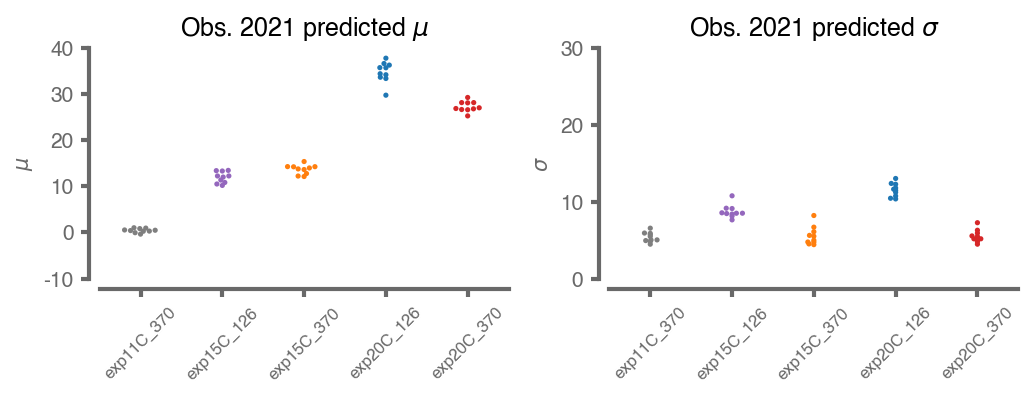

In [15]:
# PLOT ACROSS SSPs and TARGETS

EXP_FOR_PLOTTING = ('exp11C_370','exp15C_370','exp15C_126','exp20C_370','exp20C_126')
df_metrics_plot = df_metrics[df_metrics["exp_name"].isin(EXP_FOR_PLOTTING)]
df_metrics_plot = df_metrics_plot.sort_values("exp_name")
clr_order = [0,1,2,3,4,5]
#------------------------------------------------------------
fig, axs = plt.subplots(1,2,figsize=(7,2.75))

ax = axs[0]
sns.swarmplot(x="exp_name",
              y="obs_2021_mu",
              data=df_metrics_plot,
              palette=np.array(palette)[clr_order],
              size=2.5,
              ax = ax,
            )
ax.set_ylabel('$\mu$')
ax.set_title('Obs. 2021 predicted $\mu$')
ax.set_xlabel(None)
format_spines(ax)
x_labels = df_metrics_plot["exp_name"].unique()
ax.set_xticks(np.arange(0,len(x_labels)),x_labels, fontsize=FS*0.8,rotation=45)
ax.set_yticks(np.arange(-100,100,10),np.arange(-100,100,10).round())
ax.set_ylim(-10,40)

ax = axs[1]
sns.swarmplot(x="exp_name",
              y="obs_2021_sigma",
              data=df_metrics_plot,
              palette=np.array(palette)[clr_order],              
              size=2.5,
              ax=ax,
            )
ax.set_title('Obs. 2021 predicted $\sigma$',fontsize=FS*1.2)
ax.set_ylim(0,30)
ax.set_xlabel(None)
format_spines(ax)
ax.set_ylabel('$\sigma$')
x_labels = df_metrics_plot["exp_name"].unique()
ax.set_xticks(np.arange(0,len(x_labels)),x_labels, fontsize=FS*0.8,rotation=45)


plt.tight_layout()
plt.show()


## Plots across hyperparameters

### Plots across obs predictions

PARAMETER CHECK: ['[25, 25]']


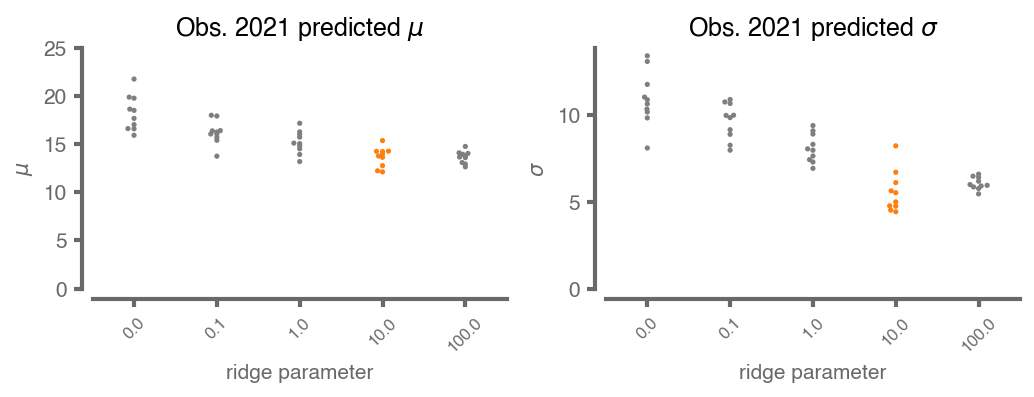

In [16]:
# PLOT ACROSS RIDGE CHOICES
EXP_FOR_PLOTTING = ('exp12','exp30','exp31','exp32','exp33')
df_metrics_plot = df_metrics[df_metrics["exp_name"].isin(EXP_FOR_PLOTTING)]
df_metrics_plot = df_metrics_plot.sort_values("ridge_param")
clr_order = [0,0,0,2,0,0,0,0,]
print('PARAMETER CHECK: ' + str(df_metrics_plot["hiddens"].unique()))
#------------------------------------------------------------
fig, axs = plt.subplots(1,2,figsize=(7,2.75))

ax = axs[0]
sns.swarmplot(x="exp_name",
              y="obs_2021_mu",
              data=df_metrics_plot,
              palette=np.array(palette)[clr_order],
              size=2.5,
              ax = ax,
            )
ax.set_ylabel('$\mu$')
ax.set_title('Obs. 2021 predicted $\mu$')
ax.set_ylim(0.0,25.0)
format_spines(ax)
ax.set_xlabel('ridge parameter',fontsize=FS)
x_labels = df_metrics_plot["ridge_param"].unique()
ax.set_xticks(np.arange(0,len(x_labels)),x_labels, fontsize=FS*0.8,rotation=45)

ax = axs[1]
sns.swarmplot(x="exp_name",
              y="obs_2021_sigma",
              data=df_metrics_plot,
              palette=np.array(palette)[clr_order],
              size=2.5,
              ax=ax,
            )
ax.set_title('Obs. 2021 predicted $\sigma$',fontsize=FS*1.2)
ax.set_ylim(0,None)
format_spines(ax)
ax.set_ylabel('$\sigma$')
ax.set_xlabel('ridge parameter',fontsize=FS)
x_labels = df_metrics_plot["ridge_param"].unique()
ax.set_xticks(np.arange(0,len(x_labels)),x_labels, fontsize=FS*0.8,rotation=45)


plt.tight_layout()
plots.savefig(FIGURE_DIRECTORY + 'obs_params_ridge_comparison',dpi=savefig_dpi)
plt.show()


PARAMETER CHECK: [10.]


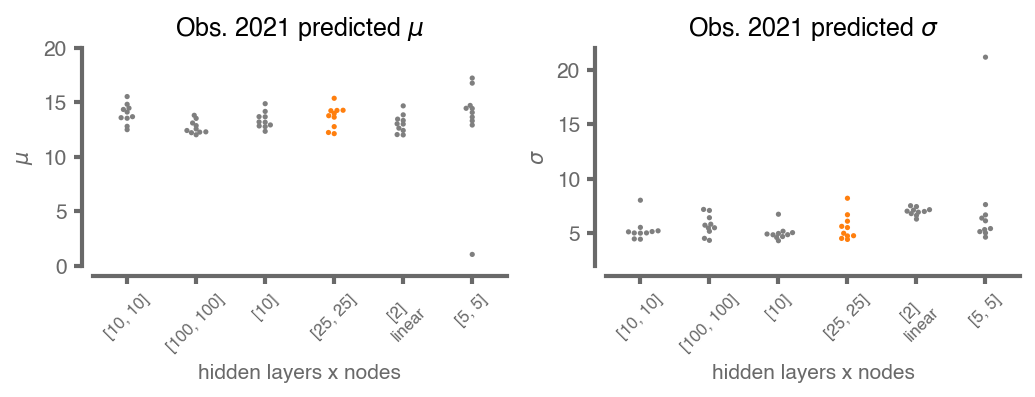

In [17]:
# PLOT ACROSS HIDDEN CHOICES

EXP_FOR_PLOTTING = ('exp5','exp10','exp11','exp12','exp13','exp14')
# EXP_FOR_PLOTTING = ('exp4','exp20','exp21','exp22','exp23',)
df_metrics_plot = df_metrics[df_metrics["exp_name"].isin(EXP_FOR_PLOTTING)]
df_metrics_plot = df_metrics_plot.sort_values("hiddens")
x_labels = df_metrics_plot["hiddens"].unique()
x_labels[x_labels=='[2]'] = '[2]\nlinear'
clr_order = [0,0,0,2,0,0,0,0,]
print('PARAMETER CHECK: ' + str(df_metrics_plot["ridge_param"].unique()))
#------------------------------------------------------------
fig, axs = plt.subplots(1,2,figsize=(7,2.75))

ax = axs[0]
sns.swarmplot(x="exp_name",
              y="obs_2021_mu",
              data=df_metrics_plot,
              palette=np.array(palette)[clr_order],
              size=2.5,
              ax = ax,
            )
ax.set_ylabel('$\mu$')
ax.set_title('Obs. 2021 predicted $\mu$')
ax.set_ylim(0.0,20.0)
format_spines(ax)
ax.set_xlabel('hidden layers x nodes',fontsize=FS)
ax.set_xticks(np.arange(0,len(x_labels)),x_labels, fontsize=FS*0.8,rotation=45)

ax = axs[1]
sns.swarmplot(x="exp_name",
              y="obs_2021_sigma",
              data=df_metrics_plot,
              palette=np.array(palette)[clr_order],
              size=2.5,
              ax=ax,
            )
ax.set_title('Obs. 2021 predicted $\sigma$',fontsize=FS*1.2)
ax.set_ylim(2,None)
format_spines(ax)
ax.set_ylabel('$\sigma$')
ax.set_xlabel('hidden layers x nodes',fontsize=FS)
ax.set_xticks(np.arange(0,len(x_labels)),x_labels, fontsize=FS*0.8,rotation=45)


plt.tight_layout()
plots.savefig(FIGURE_DIRECTORY + 'obs_params_hiddens_comparison',dpi=savefig_dpi)
plt.show()


### Error and PIT

PARAMETER CHECK: ['[25, 25]']


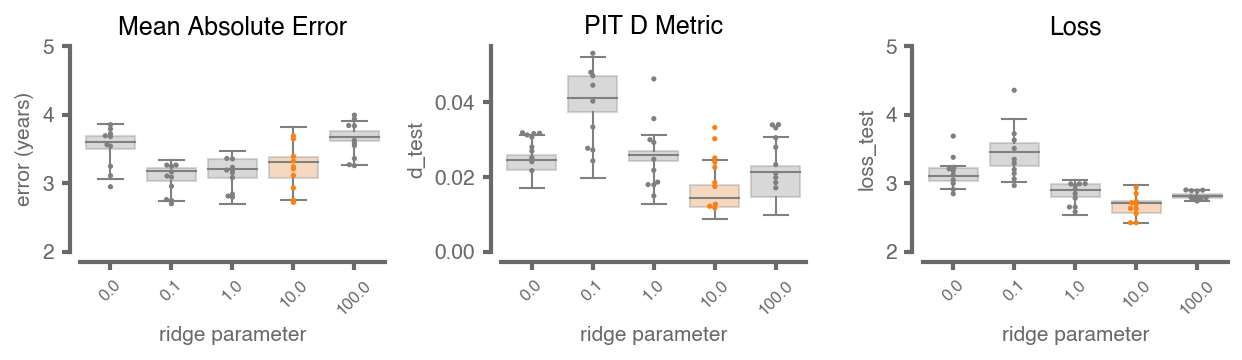

In [18]:
# PLOT ACROSS RIDGE CHOICES
EXP_FOR_PLOTTING = ('exp12','exp30','exp31','exp32','exp33')
df_metrics_plot = df_metrics[df_metrics["exp_name"].isin(EXP_FOR_PLOTTING)]
df_metrics_plot = df_metrics_plot.sort_values("ridge_param")
clr_order = [0,0,0,2,0,0,0,0,]

print('PARAMETER CHECK: ' + str(df_metrics_plot["hiddens"].unique()))
#------------------------------------------------------------
fig, axs = plt.subplots(1,3,figsize=(8.5,2.5))

ax = axs[0]
sns.boxplot(x="exp_name",
            y="error_val",
            palette=np.array(palette)[clr_order],
            data=df_metrics_plot,
            boxprops=dict(alpha=.3, edgecolor='gray',linewidth=1.),
            whiskerprops=dict(color='gray',linewidth=1.),
            medianprops=dict(color='gray',linewidth=1.),
            capprops=dict(color='gray',linewidth=1.),            
            whis=100., 
            ax = ax,
            )
sns.swarmplot(x="exp_name",
              y="error_test",
              palette=np.array(palette)[clr_order],
              data=df_metrics_plot,
              size=2.5,
              ax = ax,
            )
ax.set_ylabel('error (years)')
ax.set_title('Mean Absolute Error')
ax.set_ylim(2.0,5.0)
format_spines(ax)
ax.set_xlabel('ridge parameter',fontsize=FS)
x_labels = df_metrics_plot["ridge_param"].unique()
ax.set_xticks(np.arange(0,len(x_labels)),x_labels, fontsize=FS*0.8,rotation=45)

ax = axs[1]
sns.boxplot(x="exp_name",
            y="d_val",
            data=df_metrics_plot,
            palette=np.array(palette)[clr_order],
            whis=100., 
            boxprops=dict(alpha=.3, edgecolor='gray',linewidth=1.),
            whiskerprops=dict(color='gray',linewidth=1.),
            medianprops=dict(color='gray',linewidth=1.),
            capprops=dict(color='gray',linewidth=1.),            
            ax = ax,
            )
sns.swarmplot(x="exp_name",
              y="d_test",
              data=df_metrics_plot,
              palette=np.array(palette)[clr_order],
              size=2.5,
              ax=ax,
            )
ax.set_title('PIT D Metric',fontsize=FS*1.2)
ax.set_ylim(0,.055)
format_spines(ax)
ax.set_xlabel('ridge parameter',fontsize=FS)
x_labels = df_metrics_plot["ridge_param"].unique()
ax.set_xticks(np.arange(0,len(x_labels)),x_labels, fontsize=FS*0.8,rotation=45)

ax = axs[2]
sns.boxplot(x="exp_name",
            y="loss_val",
            data=df_metrics_plot,
            palette=np.array(palette)[clr_order],
            whis=100., 
            boxprops=dict(alpha=.3, edgecolor='gray',linewidth=1.),
            whiskerprops=dict(color='gray',linewidth=1.),
            medianprops=dict(color='gray',linewidth=1.),
            capprops=dict(color='gray',linewidth=1.),            
            ax = ax,
            )
sns.swarmplot(x="exp_name",
              y="loss_test",
              data=df_metrics_plot,
              palette=np.array(palette)[clr_order],
              size=2.5,
              ax=ax,
            )
ax.set_title('Loss',fontsize=FS*1.2)
ax.set_ylim(2.,5.0)
format_spines(ax)
ax.set_xlabel('ridge parameter',fontsize=FS)
x_labels = df_metrics_plot["ridge_param"].unique()
ax.set_xticks(np.arange(0,len(x_labels)),x_labels, fontsize=FS*0.8,rotation=45)



plt.tight_layout()
plots.savefig(FIGURE_DIRECTORY + 'cmip6_metrics_ridge_comparison',dpi=savefig_dpi)
plt.show()


PARAMETER CHECK: [10.]


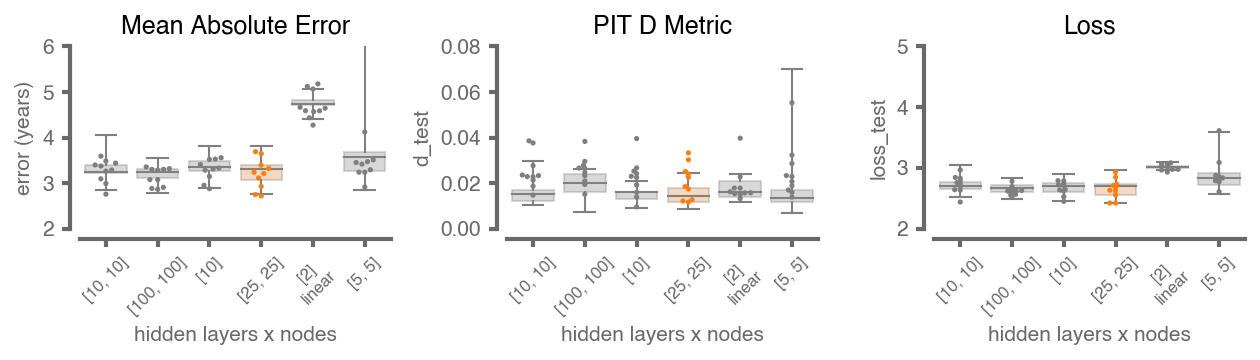

In [19]:
# PLOT ACROSS HIDDEN CHOICES
EXP_FOR_PLOTTING = ('exp5','exp10','exp11','exp12','exp13','exp14')
df_metrics_plot = df_metrics[df_metrics["exp_name"].isin(EXP_FOR_PLOTTING)]
df_metrics_plot = df_metrics_plot.sort_values("hiddens")
x_labels = df_metrics_plot["hiddens"].unique()
x_labels[x_labels=='[2]'] = '[2]\nlinear'
clr_order = [0,0,0,2,0,0,0,0,]

print('PARAMETER CHECK: ' + str(df_metrics_plot["ridge_param"].unique()))
#------------------------------------------------------------
fig, axs = plt.subplots(1,3,figsize=(8.5,2.5))

ax = axs[0]
sns.boxplot(x="exp_name",
            y="error_val",
            data=df_metrics_plot,
            palette=np.array(palette)[clr_order],
            boxprops=dict(alpha=.3, edgecolor='gray',linewidth=1.),
            whiskerprops=dict(color='gray',linewidth=1.),
            medianprops=dict(color='gray',linewidth=1.),
            capprops=dict(color='gray',linewidth=1.),            
            whis=100., 
            ax = ax,
            )
sns.swarmplot(x="exp_name",
              y="error_test",
              data=df_metrics_plot,
              palette=np.array(palette)[clr_order],
              size=2.5,
              ax = ax,
            )
ax.set_ylabel('error (years)')
ax.set_title('Mean Absolute Error')
ax.set_ylim(2.0,6.0)
format_spines(ax)
ax.set_xlabel('hidden layers x nodes',fontsize=FS)
ax.set_xticks(np.arange(0,len(x_labels)),x_labels, fontsize=FS*0.8,rotation=45)

ax = axs[1]
sns.boxplot(x="exp_name",
            y="d_val",
            data=df_metrics_plot,
            palette=np.array(palette)[clr_order],
            whis=100., 
            boxprops=dict(alpha=.3, edgecolor='gray',linewidth=1.),
            whiskerprops=dict(color='gray',linewidth=1.),
            medianprops=dict(color='gray',linewidth=1.),
            capprops=dict(color='gray',linewidth=1.),            
            ax = ax,
            )
sns.swarmplot(x="exp_name",
              y="d_test",
              data=df_metrics_plot,
              palette=np.array(palette)[clr_order],
              size=2.5,
              ax=ax,
            )
ax.set_title('PIT D Metric',fontsize=FS*1.2)
ax.set_ylim(0,.08)
format_spines(ax)
ax.set_xlabel('hidden layers x nodes',fontsize=FS)
ax.set_xticks(np.arange(0,len(x_labels)),x_labels, fontsize=FS*0.8,rotation=45)

ax = axs[2]
sns.boxplot(x="exp_name",
            y="loss_val",
            data=df_metrics_plot,
            palette=np.array(palette)[clr_order],
            whis=100., 
            boxprops=dict(alpha=.3, edgecolor='gray',linewidth=1.),
            whiskerprops=dict(color='gray',linewidth=1.),
            medianprops=dict(color='gray',linewidth=1.),
            capprops=dict(color='gray',linewidth=1.),            
            ax = ax,
            )
sns.swarmplot(x="exp_name",
              y="loss_test",
              data=df_metrics_plot,
              palette=np.array(palette)[clr_order],
              size=2.5,
              ax=ax,
            )
ax.set_title('Loss',fontsize=FS*1.2)
ax.set_ylim(2.0,5.0)
format_spines(ax)
ax.set_xlabel('hidden layers x nodes',fontsize=FS)
ax.set_xticks(np.arange(0,len(x_labels)),x_labels, fontsize=FS*0.8,rotation=45)


plt.tight_layout()
plots.savefig(FIGURE_DIRECTORY + 'cmip6_metrics_hiddens_comparison',dpi=savefig_dpi)
plt.show()


## Plot all hyperparameter experiments

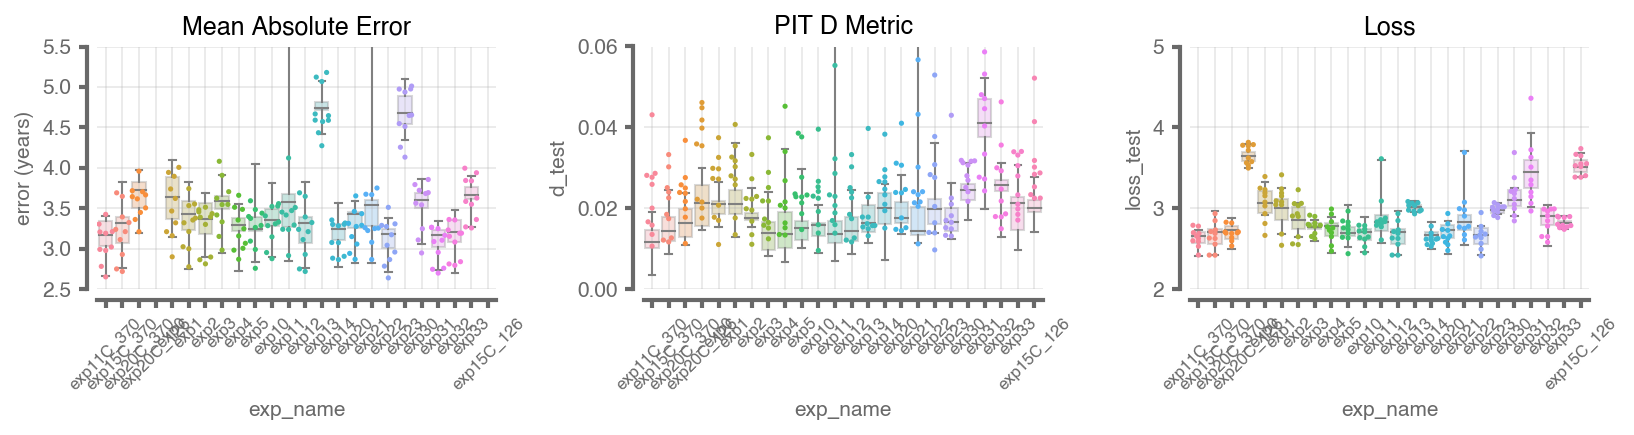

In [20]:
# PLOT ACROSS ALL EXPERIMENTS
EXP_FOR_PLOTTING = EXP_NAME_VEC
df_metrics_plot = df_metrics[df_metrics["exp_name"].isin(EXP_FOR_PLOTTING)]
x_labels = df_metrics_plot["exp_name"].unique()
clr_order = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,]
#------------------------------------------------------------
fig, axs = plt.subplots(1,3,figsize=(11,3.))

ax = axs[0]
sns.boxplot(x="exp_name",
            y="error_val",
            data=df_metrics_plot,
            # palette=np.array(palette)[clr_order],
            boxprops=dict(alpha=.3, edgecolor='gray',linewidth=1.),
            whiskerprops=dict(color='gray',linewidth=1.),
            medianprops=dict(color='gray',linewidth=1.),
            capprops=dict(color='gray',linewidth=1.),            
            whis=100., 
            ax = ax,
            )
sns.swarmplot(x="exp_name",
              y="error_test",
              data=df_metrics_plot,
              # palette=np.array(palette)[clr_order],
              size=2.5,
              ax = ax,
            )
ax.set_yticks(np.arange(0,10,.5))
ax.set_ylabel('error (years)')
ax.set_title('Mean Absolute Error')
ax.set_ylim(2.5,5.5)
format_spines(ax)
# ax.set_xlabel('hidden layers x nodes',fontsize=FS)
ax.set_xticks(np.arange(0,len(x_labels)),x_labels, fontsize=FS*0.8,rotation=45)
ax.grid(alpha=.3)

ax = axs[1]
sns.boxplot(x="exp_name",
            y="d_val",
            data=df_metrics_plot,
            # palette=np.array(palette)[clr_order],
            whis=100., 
            boxprops=dict(alpha=.3, edgecolor='gray',linewidth=1.),
            whiskerprops=dict(color='gray',linewidth=1.),
            medianprops=dict(color='gray',linewidth=1.),
            capprops=dict(color='gray',linewidth=1.),            
            ax = ax,
            )
sns.swarmplot(x="exp_name",
              y="d_test",
              data=df_metrics_plot,
              # palette=np.array(palette)[clr_order],
              size=2.5,
              ax=ax,
            )
ax.set_title('PIT D Metric',fontsize=FS*1.2)
ax.set_ylim(0,.06)
format_spines(ax)
# ax.set_xlabel('hidden layers x nodes',fontsize=FS)
ax.set_xticks(np.arange(0,len(x_labels)),x_labels, fontsize=FS*0.8,rotation=45)
ax.grid(alpha=.3)

ax = axs[2]
sns.boxplot(x="exp_name",
            y="loss_val",
            data=df_metrics_plot,
            # palette=np.array(palette)[clr_order],
            whis=100., 
            boxprops=dict(alpha=.3, edgecolor='gray',linewidth=1.),
            whiskerprops=dict(color='gray',linewidth=1.),
            medianprops=dict(color='gray',linewidth=1.),
            capprops=dict(color='gray',linewidth=1.),            
            ax = ax,
            )
sns.swarmplot(x="exp_name",
              y="loss_test",
              data=df_metrics_plot,
              # palette=np.array(palette)[clr_order],
              size=2.5,
              ax=ax,
            )
ax.set_title('Loss',fontsize=FS*1.2)
ax.set_ylim(2.0,5.0)
format_spines(ax)
# ax.set_xlabel('hidden layers x nodes',fontsize=FS)
ax.set_xticks(np.arange(0,len(x_labels)),x_labels, fontsize=FS*0.8,rotation=45)
ax.grid(alpha=.3)

plt.tight_layout()
plots.savefig(FIGURE_DIRECTORY + 'cmip6_metrics_all_comparison',dpi=savefig_dpi)
plt.show()


## Explore the dataframe

In [ ]:
EXP_NAME = 'exp12'
df = df_metrics[df_metrics["exp_name"]==EXP_NAME]
PLOT_SEED = df_metrics.iloc[df['loss_test'].idxmin()]["seed"]
# display(df_metrics.iloc[df['loss_test'].idxmin()])
display(df.sort_values("loss_val"))
# df['loss_val'].idxmax()
# display(df_metrics[df_metrics["exp_name"]=="exp4"].sort_values("error_val").head())
# PLOT_SEED = 1257


In [ ]:
# display(df_metrics[df_metrics["exp_name"]=="exp4"].sort_values("error_val").head())
# display(df_metrics[df_metrics["exp_name"]=="exp4"].sort_values("d_val").head())
# display(df_metrics[df_metrics["exp_name"]=="exp4"].sort_values("error_test").head())